In [3]:
# %%
import os
import numpy as np
import pandas as pd
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout, Masking
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow.keras.backend as K
import time

# %%
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# %%
#### Change inputs
modelID = '93ks'
## noaa stations following same order of the outputs
# NOAAstations = ['Duck', 'Oregon', 'Hatteras', 'Beaufort', 'Wilmington', 'Wrightsville']

#### Define paths and load data
# pathData = Path(r'../../../data/random_split')
pathData = Path(r'/mnt/drive1/Insyncs/NCSU/thesis/models/NNmodel/inputs/random_split')
# pathColSample = pathData.parent
pathColSample = Path(r'/mnt/drive1/Insyncs/NCSU/thesis/models/adcirc/concorde/batch02/_postprocessing/_preprocessForNN')
X_train_file = 'X_train_standardScaled_allInputs_augmentedAllX50_ALL.npy'
Y_train_file = 'y_train_augmentedAllX50_ALL.npy'
X_test_file = 'X_test_standardScaled_allInputs_augmentedAllX50_ALL.npy'
Y_test_file = 'y_test_augmentedAllX50_ALL.npy'

#### some hyperparameters
batch_size = 100
epochs = 1000
fold = 1 ## no cross validation

In [16]:
#### path to store outputs
#pathOut0 = Path(r'/mnt/drive1/Insyncs/NCSU/thesis/models/NNmodel/81')
pathOut = Path(f'../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/{modelID}')
#pathOut0 = pathOut0/st

#### class to save best model
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, pathout, fold, modelID):
        super(CustomCallback, self).__init__()
        self.pathout = pathout
        self.fold = fold
        self.modelID = modelID
        self.previous_val_loss = float('inf')  # Initialize with a high value
        self.best_epoch = None
        self.best_model = None
    
    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        if current_val_loss is not None and current_val_loss < self.previous_val_loss:
            self.model.save(self.pathout / f'bestModel_{self.modelID}_fold{self.fold}.tf')
            self.previous_val_loss = current_val_loss
            self.best_epoch = epoch
            self.best_model = self.model
            with open(self.pathout / f'best_model.txt', 'a') as fout:
                fout.write(f'Best model saved for fold {self.fold}: epoch {self.best_epoch}, val_loss: {current_val_loss:0.3f}\n')

#### load data
X_train = np.load(pathData/X_train_file)
y_train = np.load(pathData/Y_train_file)
X_test = np.load(pathData/X_test_file)
y_test = np.load(pathData/Y_test_file)

#### train/validation split
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### pathout
#pathOut = pathOut0/st

columns_sample = pd.read_csv(pathColSample/'dct_tracksAll_batch02_ALL_lengthCorr_tides_resampled_SAMPLE.csv', index_col = 0)

## inputs
cols = ['wind_speed', 'pressure', 'rad_to_max_ws', 'forward_speed_u', 'forward_speed_v',
        'wind_speed_fft', 'pressure_fft', 'rad_to_max_ws_fft', 'forward_speed_u_fft', 'forward_speed_v_fft',
            'dist_to_duck', 'dist_to_oregon', 'dist_to_hatteras', 'dist_to_beaufort', 'dist_to_wilmington', 
            'dist_to_wrightsville', 'dist_to_Albemarle', 'dist_to_Pamlico', 'dist_to_Neuse', 'Boundary']

In [20]:
## extract inputs idx from the full input array
idx_cols = [list(columns_sample).index(x) for x in cols]
X_train_sub2 = X_train_sub[:, :, idx_cols]
X_val2 = X_val[:, :, idx_cols]
X_test2 = X_test[:, :, idx_cols]

In [22]:
try:
    os.mkdir(pathOut)
except:
    pass

#### Define model
model = Sequential([
                Masking(-9999, input_shape=(X_train_sub2.shape[1:])),
                Conv1D(16, kernel_size=3, activation='relu'),
                BatchNormalization(),
                MaxPooling1D(pool_size=2),
                Conv1D(32, kernel_size=3, activation='relu'),
                BatchNormalization(),
                MaxPooling1D(pool_size=2),
                Conv1D(64, kernel_size=3, activation='relu'),
                BatchNormalization(),
                MaxPooling1D(pool_size=2),
                Flatten(),
                Dense(64, activation='relu'),
                Dropout(0.2),
                Dense(32, activation='relu'),
                Dropout(0.2),
                Dense(9, activation='relu'),
            ])

optimizer = RMSprop(learning_rate = 1e-4)
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), 
                metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
model.summary()

#### callback to save model with lower val_loss
callback = CustomCallback(pathOut, fold=fold, modelID=modelID)
#### train the model
t0 = time.time()
history = model.fit(X_train_sub2, y_train_sub, batch_size=batch_size, epochs=epochs, verbose=1,
                        validation_data = (X_val2, y_val), callbacks=[callback])
print(f'Training time: {(time.time() - t0)/3600:0.3f} hrs')

#### save outputs
dfhist = pd.DataFrame.from_dict(history.history)
dfhist.to_csv(pathOut/f'history_{modelID}_fold{fold}.csv')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 235, 20)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 233, 16)           976       
                                                                 
 batch_normalization_3 (Batc  (None, 233, 16)          64        
 hNormalization)                                                 
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 116, 16)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 114, 32)           1568      
                                                                 
 batch_normalization_4 (Batc  (None, 114, 32)         

2024-01-18 17:23:57.746452: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1182031200 exceeds 10% of free system memory.
2024-01-18 17:23:59.131835: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1182031200 exceeds 10% of free system memory.


Epoch 1/1000


2024-01-18 17:24:02.708833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-01-18 17:24:03.596010: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-18 17:24:04.461623: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f313c00c820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-18 17:24:04.461718: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro P2000, Compute Capability 6.1
2024-01-18 17:24:04.461744: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Quadro P2000, Compute Capability 6.1
2024-01-18 17:24:04.506328: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-18 17:24:04.785662: I tensorflow/tsl/platform/default/subprocess.cc

629/629 [==============================] - ETA: 0s - loss: 0.2689 - mse: 0.6431 - mae: 0.5842 - rmse: 0.8019

2024-01-18 17:24:24.207700: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 295517200 exceeds 10% of free system memory.


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 29s 35ms/step - loss: 0.2689 - mse: 0.6431 - mae: 0.5842 - rmse: 0.8019 - val_loss: 0.2033 - val_mse: 0.4909 - val_mae: 0.4578 - val_rmse: 0.7006
Epoch 2/1000
629/629 [==============================] - ETA: 0s - loss: 0.1668 - mse: 0.3690 - mae: 0.4392 - rmse: 0.6074

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 26ms/step - loss: 0.1668 - mse: 0.3690 - mae: 0.4392 - rmse: 0.6074 - val_loss: 0.2028 - val_mse: 0.4971 - val_mae: 0.4606 - val_rmse: 0.7051
Epoch 3/1000
628/629 [============================>.] - ETA: 0s - loss: 0.1359 - mse: 0.2942 - mae: 0.3903 - rmse: 0.5424

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 17s 26ms/step - loss: 0.1359 - mse: 0.2941 - mae: 0.3903 - rmse: 0.5423 - val_loss: 0.1959 - val_mse: 0.4797 - val_mae: 0.4460 - val_rmse: 0.6926
Epoch 4/1000
627/629 [============================>.] - ETA: 0s - loss: 0.1202 - mse: 0.2575 - mae: 0.3636 - rmse: 0.5075

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.1202 - mse: 0.2575 - mae: 0.3636 - rmse: 0.5075 - val_loss: 0.1914 - val_mse: 0.4704 - val_mae: 0.4379 - val_rmse: 0.6858
Epoch 5/1000
627/629 [============================>.] - ETA: 0s - loss: 0.1089 - mse: 0.2321 - mae: 0.3432 - rmse: 0.4817

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.1089 - mse: 0.2320 - mae: 0.3432 - rmse: 0.4817 - val_loss: 0.1821 - val_mse: 0.4422 - val_mae: 0.4218 - val_rmse: 0.6650
Epoch 6/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0995 - mse: 0.2110 - mae: 0.3255 - rmse: 0.4594

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0995 - mse: 0.2110 - mae: 0.3255 - rmse: 0.4594 - val_loss: 0.1664 - val_mse: 0.3948 - val_mae: 0.4007 - val_rmse: 0.6284
Epoch 7/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0928 - mse: 0.1960 - mae: 0.3129 - rmse: 0.4428

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 26ms/step - loss: 0.0928 - mse: 0.1960 - mae: 0.3129 - rmse: 0.4427 - val_loss: 0.1602 - val_mse: 0.3795 - val_mae: 0.3914 - val_rmse: 0.6160
Epoch 8/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0876 - mse: 0.1846 - mae: 0.3027 - rmse: 0.4296

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 26ms/step - loss: 0.0876 - mse: 0.1846 - mae: 0.3027 - rmse: 0.4296 - val_loss: 0.1505 - val_mse: 0.3505 - val_mae: 0.3790 - val_rmse: 0.5920
Epoch 9/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0828 - mse: 0.1739 - mae: 0.2939 - rmse: 0.4170

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0828 - mse: 0.1739 - mae: 0.2939 - rmse: 0.4170 - val_loss: 0.1326 - val_mse: 0.3018 - val_mae: 0.3522 - val_rmse: 0.5494
Epoch 10/1000
629/629 [==============================] - 14s 22ms/step - loss: 0.0791 - mse: 0.1654 - mae: 0.2870 - rmse: 0.4067 - val_loss: 0.1474 - val_mse: 0.3433 - val_mae: 0.3715 - val_rmse: 0.5859
Epoch 11/1000
629/629 [==============================] - 14s 22ms/step - loss: 0.0763 - mse: 0.1594 - mae: 0.2812 - rmse: 0.3993 - val_loss: 0.1411 - val_mse: 0.3261 - val_mae: 0.3647 - val_rmse: 0.5710
Epoch 12/1000
629/629 [==============================] - 14s 22ms/step - loss: 0.0732 - mse: 0.1525 - mae: 0.2755 - rmse: 0.3905 - val_loss: 0.1481 - val_mse: 0.3477 - val_mae: 0.3730 - val_rmse: 0.5896
Epoch 13/1000
629/629 [==============================] - 14s 22ms/step - loss: 0.0709 - mse: 0.1474 - mae: 0.2708 - rmse: 0.3839 - val_loss: 0.1350 - val_mse: 0.3097 - val_mae: 0.3521 - val_rmse: 0.5565

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0591 - mse: 0.1218 - mae: 0.2463 - rmse: 0.3490 - val_loss: 0.1227 - val_mse: 0.2760 - val_mae: 0.3323 - val_rmse: 0.5253
Epoch 22/1000
629/629 [==============================] - 14s 22ms/step - loss: 0.0584 - mse: 0.1202 - mae: 0.2447 - rmse: 0.3467 - val_loss: 0.1426 - val_mse: 0.3303 - val_mae: 0.3585 - val_rmse: 0.5747
Epoch 23/1000
629/629 [==============================] - 14s 22ms/step - loss: 0.0574 - mse: 0.1181 - mae: 0.2427 - rmse: 0.3436 - val_loss: 0.1375 - val_mse: 0.3151 - val_mae: 0.3520 - val_rmse: 0.5614
Epoch 24/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0568 - mse: 0.1168 - mae: 0.2413 - rmse: 0.3418 - val_loss: 0.1263 - val_mse: 0.2860 - val_mae: 0.3360 - val_rmse: 0.5348
Epoch 25/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0558 - mse: 0.1145 - mae: 0.2393 - rmse: 0.3384 - val_loss: 0.1420 - val_mse: 0.3280 - val_mae: 0.3573 - val_rmse: 0.5727

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0528 - mse: 0.1082 - mae: 0.2331 - rmse: 0.3290 - val_loss: 0.1152 - val_mse: 0.2554 - val_mae: 0.3209 - val_rmse: 0.5054
Epoch 30/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0522 - mse: 0.1069 - mae: 0.2317 - rmse: 0.3269

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0522 - mse: 0.1069 - mae: 0.2317 - rmse: 0.3270 - val_loss: 0.1115 - val_mse: 0.2442 - val_mae: 0.3159 - val_rmse: 0.4942
Epoch 31/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0515 - mse: 0.1053 - mae: 0.2303 - rmse: 0.3245

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0515 - mse: 0.1053 - mae: 0.2303 - rmse: 0.3245 - val_loss: 0.1103 - val_mse: 0.2416 - val_mae: 0.3144 - val_rmse: 0.4916
Epoch 32/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0511 - mse: 0.1045 - mae: 0.2295 - rmse: 0.3232 - val_loss: 0.1161 - val_mse: 0.2551 - val_mae: 0.3237 - val_rmse: 0.5051
Epoch 33/1000
629/629 [==============================] - ETA: 0s - loss: 0.0506 - mse: 0.1034 - mae: 0.2282 - rmse: 0.3216

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0506 - mse: 0.1034 - mae: 0.2282 - rmse: 0.3216 - val_loss: 0.0952 - val_mse: 0.2020 - val_mae: 0.2944 - val_rmse: 0.4495
Epoch 34/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0499 - mse: 0.1020 - mae: 0.2267 - rmse: 0.3193 - val_loss: 0.1047 - val_mse: 0.2246 - val_mae: 0.3092 - val_rmse: 0.4739
Epoch 35/1000
629/629 [==============================] - ETA: 0s - loss: 0.0492 - mse: 0.1003 - mae: 0.2256 - rmse: 0.3167

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0492 - mse: 0.1003 - mae: 0.2256 - rmse: 0.3167 - val_loss: 0.0856 - val_mse: 0.1798 - val_mae: 0.2797 - val_rmse: 0.4240
Epoch 36/1000
629/629 [==============================] - 14s 21ms/step - loss: 0.0491 - mse: 0.1001 - mae: 0.2250 - rmse: 0.3164 - val_loss: 0.1019 - val_mse: 0.2188 - val_mae: 0.3035 - val_rmse: 0.4678
Epoch 37/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0484 - mse: 0.0987 - mae: 0.2236 - rmse: 0.3141

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0484 - mse: 0.0987 - mae: 0.2237 - rmse: 0.3142 - val_loss: 0.0783 - val_mse: 0.1626 - val_mae: 0.2691 - val_rmse: 0.4033
Epoch 38/1000
629/629 [==============================] - 14s 22ms/step - loss: 0.0483 - mse: 0.0984 - mae: 0.2234 - rmse: 0.3138 - val_loss: 0.1167 - val_mse: 0.2566 - val_mae: 0.3236 - val_rmse: 0.5065
Epoch 39/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0475 - mse: 0.0968 - mae: 0.2217 - rmse: 0.3111 - val_loss: 0.0804 - val_mse: 0.1673 - val_mae: 0.2729 - val_rmse: 0.4090
Epoch 40/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0473 - mse: 0.0963 - mae: 0.2210 - rmse: 0.3104

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0473 - mse: 0.0963 - mae: 0.2210 - rmse: 0.3104 - val_loss: 0.0764 - val_mse: 0.1581 - val_mae: 0.2660 - val_rmse: 0.3976
Epoch 41/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0468 - mse: 0.0952 - mae: 0.2203 - rmse: 0.3086

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0468 - mse: 0.0952 - mae: 0.2203 - rmse: 0.3086 - val_loss: 0.0723 - val_mse: 0.1487 - val_mae: 0.2602 - val_rmse: 0.3857
Epoch 42/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0462 - mse: 0.0940 - mae: 0.2189 - rmse: 0.3065 - val_loss: 0.0774 - val_mse: 0.1609 - val_mae: 0.2673 - val_rmse: 0.4011
Epoch 43/1000
629/629 [==============================] - 14s 21ms/step - loss: 0.0458 - mse: 0.0931 - mae: 0.2180 - rmse: 0.3052 - val_loss: 0.0852 - val_mse: 0.1775 - val_mae: 0.2807 - val_rmse: 0.4213
Epoch 44/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0457 - mse: 0.0929 - mae: 0.2174 - rmse: 0.3049

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0457 - mse: 0.0929 - mae: 0.2174 - rmse: 0.3049 - val_loss: 0.0651 - val_mse: 0.1330 - val_mae: 0.2496 - val_rmse: 0.3647
Epoch 45/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0456 - mse: 0.0929 - mae: 0.2175 - rmse: 0.3048 - val_loss: 0.0694 - val_mse: 0.1423 - val_mae: 0.2562 - val_rmse: 0.3772
Epoch 46/1000
629/629 [==============================] - ETA: 0s - loss: 0.0450 - mse: 0.0914 - mae: 0.2161 - rmse: 0.3023

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0450 - mse: 0.0914 - mae: 0.2161 - rmse: 0.3023 - val_loss: 0.0555 - val_mse: 0.1126 - val_mae: 0.2331 - val_rmse: 0.3356
Epoch 47/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0448 - mse: 0.0911 - mae: 0.2158 - rmse: 0.3019

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0449 - mse: 0.0911 - mae: 0.2159 - rmse: 0.3019 - val_loss: 0.0458 - val_mse: 0.0922 - val_mae: 0.2155 - val_rmse: 0.3037
Epoch 48/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0445 - mse: 0.0905 - mae: 0.2151 - rmse: 0.3009 - val_loss: 0.0591 - val_mse: 0.1200 - val_mae: 0.2399 - val_rmse: 0.3465
Epoch 49/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0441 - mse: 0.0897 - mae: 0.2138 - rmse: 0.2994 - val_loss: 0.0509 - val_mse: 0.1027 - val_mae: 0.2258 - val_rmse: 0.3205
Epoch 50/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0436 - mse: 0.0885 - mae: 0.2129 - rmse: 0.2976 - val_loss: 0.0495 - val_mse: 0.0999 - val_mae: 0.2222 - val_rmse: 0.3161
Epoch 51/1000
629/629 [==============================] - 14s 22ms/step - loss: 0.0436 - mse: 0.0885 - mae: 0.2128 - rmse: 0.2976 - val_loss: 0.0490 - val_mse: 0.0989 - val_mae: 0.2209 - val_rmse: 0.3145

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0433 - mse: 0.0880 - mae: 0.2122 - rmse: 0.2967 - val_loss: 0.0431 - val_mse: 0.0868 - val_mae: 0.2102 - val_rmse: 0.2946
Epoch 53/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0431 - mse: 0.0874 - mae: 0.2117 - rmse: 0.2957 - val_loss: 0.0484 - val_mse: 0.0974 - val_mae: 0.2204 - val_rmse: 0.3122
Epoch 54/1000
629/629 [==============================] - ETA: 0s - loss: 0.0428 - mse: 0.0869 - mae: 0.2112 - rmse: 0.2949

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0428 - mse: 0.0869 - mae: 0.2112 - rmse: 0.2949 - val_loss: 0.0417 - val_mse: 0.0839 - val_mae: 0.2076 - val_rmse: 0.2897
Epoch 55/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0427 - mse: 0.0867 - mae: 0.2108 - rmse: 0.2945

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0427 - mse: 0.0868 - mae: 0.2108 - rmse: 0.2946 - val_loss: 0.0313 - val_mse: 0.0628 - val_mae: 0.1835 - val_rmse: 0.2505
Epoch 56/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0423 - mse: 0.0858 - mae: 0.2099 - rmse: 0.2929 - val_loss: 0.0326 - val_mse: 0.0655 - val_mae: 0.1864 - val_rmse: 0.2560
Epoch 57/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0420 - mse: 0.0853 - mae: 0.2093 - rmse: 0.2920

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0420 - mse: 0.0852 - mae: 0.2093 - rmse: 0.2920 - val_loss: 0.0312 - val_mse: 0.0625 - val_mae: 0.1831 - val_rmse: 0.2500
Epoch 58/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0420 - mse: 0.0853 - mae: 0.2091 - rmse: 0.2920

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0420 - mse: 0.0852 - mae: 0.2091 - rmse: 0.2920 - val_loss: 0.0295 - val_mse: 0.0591 - val_mae: 0.1786 - val_rmse: 0.2431
Epoch 59/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0418 - mse: 0.0848 - mae: 0.2084 - rmse: 0.2912 - val_loss: 0.0320 - val_mse: 0.0642 - val_mae: 0.1845 - val_rmse: 0.2534
Epoch 60/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0415 - mse: 0.0842 - mae: 0.2078 - rmse: 0.2902 - val_loss: 0.0306 - val_mse: 0.0615 - val_mae: 0.1811 - val_rmse: 0.2479
Epoch 61/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0410 - mse: 0.0832 - mae: 0.2069 - rmse: 0.2885 - val_loss: 0.0323 - val_mse: 0.0649 - val_mae: 0.1860 - val_rmse: 0.2548
Epoch 62/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0409 - mse: 0.0830 - mae: 0.2065 - rmse: 0.2880

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0409 - mse: 0.0830 - mae: 0.2065 - rmse: 0.2880 - val_loss: 0.0289 - val_mse: 0.0581 - val_mae: 0.1757 - val_rmse: 0.2410
Epoch 63/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0406 - mse: 0.0824 - mae: 0.2058 - rmse: 0.2871

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0406 - mse: 0.0824 - mae: 0.2058 - rmse: 0.2871 - val_loss: 0.0263 - val_mse: 0.0527 - val_mae: 0.1687 - val_rmse: 0.2295
Epoch 64/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0407 - mse: 0.0825 - mae: 0.2059 - rmse: 0.2873 - val_loss: 0.0265 - val_mse: 0.0532 - val_mae: 0.1705 - val_rmse: 0.2306
Epoch 65/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0405 - mse: 0.0820 - mae: 0.2054 - rmse: 0.2863

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0405 - mse: 0.0820 - mae: 0.2054 - rmse: 0.2863 - val_loss: 0.0250 - val_mse: 0.0502 - val_mae: 0.1654 - val_rmse: 0.2240
Epoch 66/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0402 - mse: 0.0815 - mae: 0.2048 - rmse: 0.2855 - val_loss: 0.0298 - val_mse: 0.0597 - val_mae: 0.1793 - val_rmse: 0.2444
Epoch 67/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0403 - mse: 0.0816 - mae: 0.2048 - rmse: 0.2857

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0403 - mse: 0.0817 - mae: 0.2048 - rmse: 0.2858 - val_loss: 0.0249 - val_mse: 0.0500 - val_mae: 0.1651 - val_rmse: 0.2236
Epoch 68/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0395 - mse: 0.0800 - mae: 0.2031 - rmse: 0.2829 - val_loss: 0.0261 - val_mse: 0.0522 - val_mae: 0.1684 - val_rmse: 0.2286
Epoch 69/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0398 - mse: 0.0807 - mae: 0.2039 - rmse: 0.2841

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0398 - mse: 0.0807 - mae: 0.2039 - rmse: 0.2841 - val_loss: 0.0239 - val_mse: 0.0478 - val_mae: 0.1620 - val_rmse: 0.2187
Epoch 70/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0395 - mse: 0.0800 - mae: 0.2029 - rmse: 0.2829 - val_loss: 0.0278 - val_mse: 0.0558 - val_mae: 0.1729 - val_rmse: 0.2362
Epoch 71/1000
629/629 [==============================] - ETA: 0s - loss: 0.0394 - mse: 0.0798 - mae: 0.2026 - rmse: 0.2825

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0394 - mse: 0.0798 - mae: 0.2026 - rmse: 0.2825 - val_loss: 0.0233 - val_mse: 0.0467 - val_mae: 0.1604 - val_rmse: 0.2162
Epoch 72/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0393 - mse: 0.0796 - mae: 0.2024 - rmse: 0.2822

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0393 - mse: 0.0797 - mae: 0.2024 - rmse: 0.2822 - val_loss: 0.0230 - val_mse: 0.0461 - val_mae: 0.1596 - val_rmse: 0.2146
Epoch 73/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0390 - mse: 0.0790 - mae: 0.2016 - rmse: 0.2810 - val_loss: 0.0239 - val_mse: 0.0479 - val_mae: 0.1616 - val_rmse: 0.2188
Epoch 74/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0390 - mse: 0.0790 - mae: 0.2014 - rmse: 0.2810 - val_loss: 0.0244 - val_mse: 0.0489 - val_mae: 0.1642 - val_rmse: 0.2211
Epoch 75/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0387 - mse: 0.0783 - mae: 0.2009 - rmse: 0.2799 - val_loss: 0.0250 - val_mse: 0.0501 - val_mae: 0.1658 - val_rmse: 0.2238
Epoch 76/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0384 - mse: 0.0776 - mae: 0.2002 - rmse: 0.2786 - val_loss: 0.0239 - val_mse: 0.0478 - val_mae: 0.1619 - val_rmse: 0.2187

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0374 - mse: 0.0757 - mae: 0.1972 - rmse: 0.2751 - val_loss: 0.0227 - val_mse: 0.0455 - val_mae: 0.1582 - val_rmse: 0.2132
Epoch 86/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0372 - mse: 0.0752 - mae: 0.1969 - rmse: 0.2743

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0372 - mse: 0.0752 - mae: 0.1969 - rmse: 0.2743 - val_loss: 0.0214 - val_mse: 0.0429 - val_mae: 0.1545 - val_rmse: 0.2072
Epoch 87/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0371 - mse: 0.0751 - mae: 0.1969 - rmse: 0.2741 - val_loss: 0.0224 - val_mse: 0.0448 - val_mae: 0.1575 - val_rmse: 0.2116
Epoch 88/1000
629/629 [==============================] - ETA: 0s - loss: 0.0370 - mse: 0.0748 - mae: 0.1965 - rmse: 0.2735

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0370 - mse: 0.0748 - mae: 0.1965 - rmse: 0.2735 - val_loss: 0.0214 - val_mse: 0.0428 - val_mae: 0.1541 - val_rmse: 0.2069
Epoch 89/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0370 - mse: 0.0748 - mae: 0.1965 - rmse: 0.2735 - val_loss: 0.0224 - val_mse: 0.0448 - val_mae: 0.1575 - val_rmse: 0.2117
Epoch 90/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0368 - mse: 0.0745 - mae: 0.1961 - rmse: 0.2729 - val_loss: 0.0252 - val_mse: 0.0506 - val_mae: 0.1664 - val_rmse: 0.2249
Epoch 91/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0366 - mse: 0.0740 - mae: 0.1955 - rmse: 0.2720 - val_loss: 0.0219 - val_mse: 0.0439 - val_mae: 0.1556 - val_rmse: 0.2096
Epoch 92/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0365 - mse: 0.0737 - mae: 0.1953 - rmse: 0.2715 - val_loss: 0.0216 - val_mse: 0.0433 - val_mae: 0.1551 - val_rmse: 0.2081

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0362 - mse: 0.0733 - mae: 0.1947 - rmse: 0.2708 - val_loss: 0.0208 - val_mse: 0.0416 - val_mae: 0.1518 - val_rmse: 0.2039
Epoch 97/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0361 - mse: 0.0731 - mae: 0.1943 - rmse: 0.2703 - val_loss: 0.0243 - val_mse: 0.0487 - val_mae: 0.1634 - val_rmse: 0.2206
Epoch 98/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0360 - mse: 0.0728 - mae: 0.1938 - rmse: 0.2699 - val_loss: 0.0261 - val_mse: 0.0522 - val_mae: 0.1690 - val_rmse: 0.2286
Epoch 99/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0356 - mse: 0.0720 - mae: 0.1932 - rmse: 0.2684

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0356 - mse: 0.0720 - mae: 0.1932 - rmse: 0.2683 - val_loss: 0.0207 - val_mse: 0.0414 - val_mae: 0.1518 - val_rmse: 0.2035
Epoch 100/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0358 - mse: 0.0724 - mae: 0.1935 - rmse: 0.2691 - val_loss: 0.0208 - val_mse: 0.0416 - val_mae: 0.1520 - val_rmse: 0.2041
Epoch 101/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0356 - mse: 0.0720 - mae: 0.1930 - rmse: 0.2684

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0356 - mse: 0.0721 - mae: 0.1931 - rmse: 0.2685 - val_loss: 0.0201 - val_mse: 0.0401 - val_mae: 0.1496 - val_rmse: 0.2004
Epoch 102/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0355 - mse: 0.0718 - mae: 0.1927 - rmse: 0.2680 - val_loss: 0.0201 - val_mse: 0.0402 - val_mae: 0.1499 - val_rmse: 0.2005
Epoch 103/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0356 - mse: 0.0720 - mae: 0.1928 - rmse: 0.2683 - val_loss: 0.0217 - val_mse: 0.0434 - val_mae: 0.1546 - val_rmse: 0.2083
Epoch 104/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0350 - mse: 0.0709 - mae: 0.1916 - rmse: 0.2662 - val_loss: 0.0203 - val_mse: 0.0406 - val_mae: 0.1506 - val_rmse: 0.2016
Epoch 105/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0352 - mse: 0.0712 - mae: 0.1920 - rmse: 0.2669 - val_loss: 0.0204 - val_mse: 0.0408 - val_mae: 0.1510 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0351 - mse: 0.0711 - mae: 0.1914 - rmse: 0.2666 - val_loss: 0.0199 - val_mse: 0.0398 - val_mae: 0.1489 - val_rmse: 0.1994
Epoch 108/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0347 - mse: 0.0701 - mae: 0.1909 - rmse: 0.2648 - val_loss: 0.0206 - val_mse: 0.0412 - val_mae: 0.1512 - val_rmse: 0.2029
Epoch 109/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0348 - mse: 0.0703 - mae: 0.1907 - rmse: 0.2652 - val_loss: 0.0207 - val_mse: 0.0414 - val_mae: 0.1512 - val_rmse: 0.2034
Epoch 110/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0349 - mse: 0.0705 - mae: 0.1910 - rmse: 0.2656 - val_loss: 0.0203 - val_mse: 0.0407 - val_mae: 0.1508 - val_rmse: 0.2016
Epoch 111/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0347 - mse: 0.0701 - mae: 0.1907 - rmse: 0.2648 - val_loss: 0.0206 - val_mse: 0.0412 - val_mae: 0.1511 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0344 - mse: 0.0695 - mae: 0.1898 - rmse: 0.2636 - val_loss: 0.0194 - val_mse: 0.0389 - val_mae: 0.1475 - val_rmse: 0.1973
Epoch 114/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0345 - mse: 0.0697 - mae: 0.1898 - rmse: 0.2640 - val_loss: 0.0221 - val_mse: 0.0443 - val_mae: 0.1560 - val_rmse: 0.2104
Epoch 115/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0347 - mse: 0.0700 - mae: 0.1903 - rmse: 0.2646

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0347 - mse: 0.0700 - mae: 0.1903 - rmse: 0.2646 - val_loss: 0.0193 - val_mse: 0.0386 - val_mae: 0.1469 - val_rmse: 0.1966
Epoch 116/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0344 - mse: 0.0694 - mae: 0.1897 - rmse: 0.2635 - val_loss: 0.0213 - val_mse: 0.0427 - val_mae: 0.1541 - val_rmse: 0.2066
Epoch 117/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0342 - mse: 0.0690 - mae: 0.1891 - rmse: 0.2628

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0342 - mse: 0.0691 - mae: 0.1891 - rmse: 0.2628 - val_loss: 0.0190 - val_mse: 0.0380 - val_mae: 0.1461 - val_rmse: 0.1951
Epoch 118/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0341 - mse: 0.0690 - mae: 0.1891 - rmse: 0.2627 - val_loss: 0.0203 - val_mse: 0.0407 - val_mae: 0.1501 - val_rmse: 0.2017
Epoch 119/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0341 - mse: 0.0690 - mae: 0.1889 - rmse: 0.2627 - val_loss: 0.0193 - val_mse: 0.0386 - val_mae: 0.1467 - val_rmse: 0.1966
Epoch 120/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0343 - mse: 0.0692 - mae: 0.1892 - rmse: 0.2631 - val_loss: 0.0206 - val_mse: 0.0413 - val_mae: 0.1516 - val_rmse: 0.2032
Epoch 121/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0341 - mse: 0.0688 - mae: 0.1887 - rmse: 0.2624 - val_loss: 0.0196 - val_mse: 0.0393 - val_mae: 0.1479 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0336 - mse: 0.0677 - mae: 0.1876 - rmse: 0.2603 - val_loss: 0.0189 - val_mse: 0.0378 - val_mae: 0.1453 - val_rmse: 0.1945
Epoch 125/1000
629/629 [==============================] - 14s 22ms/step - loss: 0.0338 - mse: 0.0684 - mae: 0.1883 - rmse: 0.2614 - val_loss: 0.0193 - val_mse: 0.0387 - val_mae: 0.1470 - val_rmse: 0.1966
Epoch 126/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0336 - mse: 0.0679 - mae: 0.1874 - rmse: 0.2606 - val_loss: 0.0189 - val_mse: 0.0378 - val_mae: 0.1449 - val_rmse: 0.1945
Epoch 127/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0335 - mse: 0.0677 - mae: 0.1873 - rmse: 0.2602 - val_loss: 0.0190 - val_mse: 0.0380 - val_mae: 0.1462 - val_rmse: 0.1949
Epoch 128/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0335 - mse: 0.0678 - mae: 0.1872 - rmse: 0.2603 - val_loss: 0.0192 - val_mse: 0.0385 - val_mae: 0.1470 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0333 - mse: 0.0672 - mae: 0.1867 - rmse: 0.2593 - val_loss: 0.0187 - val_mse: 0.0375 - val_mae: 0.1448 - val_rmse: 0.1937
Epoch 132/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0332 - mse: 0.0671 - mae: 0.1864 - rmse: 0.2590

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0332 - mse: 0.0671 - mae: 0.1864 - rmse: 0.2591 - val_loss: 0.0187 - val_mse: 0.0374 - val_mae: 0.1442 - val_rmse: 0.1935
Epoch 133/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0332 - mse: 0.0671 - mae: 0.1864 - rmse: 0.2590

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0332 - mse: 0.0671 - mae: 0.1864 - rmse: 0.2590 - val_loss: 0.0183 - val_mse: 0.0365 - val_mae: 0.1426 - val_rmse: 0.1912
Epoch 134/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0332 - mse: 0.0671 - mae: 0.1863 - rmse: 0.2590

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0332 - mse: 0.0671 - mae: 0.1863 - rmse: 0.2590 - val_loss: 0.0180 - val_mse: 0.0360 - val_mae: 0.1421 - val_rmse: 0.1898
Epoch 135/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0330 - mse: 0.0665 - mae: 0.1858 - rmse: 0.2580 - val_loss: 0.0181 - val_mse: 0.0362 - val_mae: 0.1423 - val_rmse: 0.1902
Epoch 136/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0332 - mse: 0.0671 - mae: 0.1862 - rmse: 0.2591 - val_loss: 0.0184 - val_mse: 0.0367 - val_mae: 0.1435 - val_rmse: 0.1917
Epoch 137/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0327 - mse: 0.0661 - mae: 0.1850 - rmse: 0.2570 - val_loss: 0.0202 - val_mse: 0.0404 - val_mae: 0.1495 - val_rmse: 0.2011
Epoch 138/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0329 - mse: 0.0665 - mae: 0.1855 - rmse: 0.2578 - val_loss: 0.0189 - val_mse: 0.0378 - val_mae: 0.1449 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0329 - mse: 0.0665 - mae: 0.1855 - rmse: 0.2579 - val_loss: 0.0179 - val_mse: 0.0359 - val_mae: 0.1421 - val_rmse: 0.1895
Epoch 140/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0326 - mse: 0.0658 - mae: 0.1848 - rmse: 0.2566 - val_loss: 0.0188 - val_mse: 0.0376 - val_mae: 0.1449 - val_rmse: 0.1939
Epoch 141/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0324 - mse: 0.0653 - mae: 0.1841 - rmse: 0.2556 - val_loss: 0.0197 - val_mse: 0.0395 - val_mae: 0.1487 - val_rmse: 0.1987
Epoch 142/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0324 - mse: 0.0654 - mae: 0.1843 - rmse: 0.2558

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0324 - mse: 0.0654 - mae: 0.1843 - rmse: 0.2557 - val_loss: 0.0178 - val_mse: 0.0355 - val_mae: 0.1415 - val_rmse: 0.1885
Epoch 143/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0325 - mse: 0.0658 - mae: 0.1845 - rmse: 0.2564 - val_loss: 0.0191 - val_mse: 0.0383 - val_mae: 0.1464 - val_rmse: 0.1956
Epoch 144/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0323 - mse: 0.0653 - mae: 0.1838 - rmse: 0.2555 - val_loss: 0.0212 - val_mse: 0.0424 - val_mae: 0.1524 - val_rmse: 0.2058
Epoch 145/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0323 - mse: 0.0652 - mae: 0.1837 - rmse: 0.2554 - val_loss: 0.0192 - val_mse: 0.0384 - val_mae: 0.1459 - val_rmse: 0.1959
Epoch 146/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0323 - mse: 0.0651 - mae: 0.1837 - rmse: 0.2552 - val_loss: 0.0194 - val_mse: 0.0389 - val_mae: 0.1471 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0318 - mse: 0.0642 - mae: 0.1823 - rmse: 0.2533 - val_loss: 0.0177 - val_mse: 0.0353 - val_mae: 0.1402 - val_rmse: 0.1879
Epoch 153/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0315 - mse: 0.0636 - mae: 0.1815 - rmse: 0.2521 - val_loss: 0.0181 - val_mse: 0.0363 - val_mae: 0.1417 - val_rmse: 0.1904
Epoch 154/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0316 - mse: 0.0639 - mae: 0.1816 - rmse: 0.2528 - val_loss: 0.0186 - val_mse: 0.0372 - val_mae: 0.1435 - val_rmse: 0.1928
Epoch 155/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0316 - mse: 0.0638 - mae: 0.1816 - rmse: 0.2526 - val_loss: 0.0177 - val_mse: 0.0354 - val_mae: 0.1400 - val_rmse: 0.1881
Epoch 156/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0316 - mse: 0.0638 - mae: 0.1817 - rmse: 0.2526

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0316 - mse: 0.0638 - mae: 0.1817 - rmse: 0.2525 - val_loss: 0.0173 - val_mse: 0.0347 - val_mae: 0.1390 - val_rmse: 0.1862
Epoch 157/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0315 - mse: 0.0636 - mae: 0.1814 - rmse: 0.2523

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0315 - mse: 0.0637 - mae: 0.1814 - rmse: 0.2523 - val_loss: 0.0172 - val_mse: 0.0344 - val_mae: 0.1380 - val_rmse: 0.1854
Epoch 158/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0316 - mse: 0.0637 - mae: 0.1816 - rmse: 0.2525 - val_loss: 0.0180 - val_mse: 0.0359 - val_mae: 0.1409 - val_rmse: 0.1896
Epoch 159/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0313 - mse: 0.0633 - mae: 0.1810 - rmse: 0.2515

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0313 - mse: 0.0633 - mae: 0.1809 - rmse: 0.2515 - val_loss: 0.0166 - val_mse: 0.0331 - val_mae: 0.1362 - val_rmse: 0.1820
Epoch 160/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0314 - mse: 0.0633 - mae: 0.1810 - rmse: 0.2516

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0314 - mse: 0.0634 - mae: 0.1810 - rmse: 0.2517 - val_loss: 0.0165 - val_mse: 0.0331 - val_mae: 0.1361 - val_rmse: 0.1818
Epoch 161/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0313 - mse: 0.0631 - mae: 0.1808 - rmse: 0.2513 - val_loss: 0.0165 - val_mse: 0.0331 - val_mae: 0.1365 - val_rmse: 0.1819
Epoch 162/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0314 - mse: 0.0634 - mae: 0.1808 - rmse: 0.2517 - val_loss: 0.0178 - val_mse: 0.0356 - val_mae: 0.1409 - val_rmse: 0.1888
Epoch 163/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0313 - mse: 0.0632 - mae: 0.1805 - rmse: 0.2514 - val_loss: 0.0175 - val_mse: 0.0351 - val_mae: 0.1398 - val_rmse: 0.1873
Epoch 164/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0311 - mse: 0.0629 - mae: 0.1801 - rmse: 0.2507 - val_loss: 0.0170 - val_mse: 0.0340 - val_mae: 0.1375 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0306 - mse: 0.0619 - mae: 0.1790 - rmse: 0.2487 - val_loss: 0.0162 - val_mse: 0.0324 - val_mae: 0.1346 - val_rmse: 0.1801
Epoch 171/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0308 - mse: 0.0621 - mae: 0.1791 - rmse: 0.2492 - val_loss: 0.0168 - val_mse: 0.0336 - val_mae: 0.1366 - val_rmse: 0.1834
Epoch 172/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0306 - mse: 0.0619 - mae: 0.1786 - rmse: 0.2487 - val_loss: 0.0165 - val_mse: 0.0329 - val_mae: 0.1360 - val_rmse: 0.1815
Epoch 173/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0307 - mse: 0.0620 - mae: 0.1788 - rmse: 0.2489 - val_loss: 0.0165 - val_mse: 0.0331 - val_mae: 0.1355 - val_rmse: 0.1819
Epoch 174/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0304 - mse: 0.0612 - mae: 0.1781 - rmse: 0.2474 - val_loss: 0.0172 - val_mse: 0.0345 - val_mae: 0.1382 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0304 - mse: 0.0613 - mae: 0.1778 - rmse: 0.2476 - val_loss: 0.0159 - val_mse: 0.0317 - val_mae: 0.1330 - val_rmse: 0.1781
Epoch 178/1000
629/629 [==============================] - 14s 22ms/step - loss: 0.0303 - mse: 0.0611 - mae: 0.1777 - rmse: 0.2472 - val_loss: 0.0160 - val_mse: 0.0319 - val_mae: 0.1344 - val_rmse: 0.1787
Epoch 179/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0303 - mse: 0.0611 - mae: 0.1776 - rmse: 0.2473 - val_loss: 0.0160 - val_mse: 0.0321 - val_mae: 0.1335 - val_rmse: 0.1791
Epoch 180/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0302 - mse: 0.0610 - mae: 0.1777 - rmse: 0.2470 - val_loss: 0.0162 - val_mse: 0.0324 - val_mae: 0.1346 - val_rmse: 0.1800
Epoch 181/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0302 - mse: 0.0610 - mae: 0.1775 - rmse: 0.2470 - val_loss: 0.0164 - val_mse: 0.0328 - val_mae: 0.1354 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0302 - mse: 0.0610 - mae: 0.1773 - rmse: 0.2470 - val_loss: 0.0155 - val_mse: 0.0311 - val_mae: 0.1323 - val_rmse: 0.1764
Epoch 184/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0302 - mse: 0.0610 - mae: 0.1772 - rmse: 0.2470 - val_loss: 0.0159 - val_mse: 0.0318 - val_mae: 0.1333 - val_rmse: 0.1784
Epoch 185/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0299 - mse: 0.0604 - mae: 0.1768 - rmse: 0.2458 - val_loss: 0.0170 - val_mse: 0.0341 - val_mae: 0.1369 - val_rmse: 0.1846
Epoch 186/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0299 - mse: 0.0602 - mae: 0.1765 - rmse: 0.2454

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0299 - mse: 0.0602 - mae: 0.1765 - rmse: 0.2455 - val_loss: 0.0154 - val_mse: 0.0309 - val_mae: 0.1318 - val_rmse: 0.1757
Epoch 187/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0300 - mse: 0.0604 - mae: 0.1765 - rmse: 0.2458 - val_loss: 0.0175 - val_mse: 0.0350 - val_mae: 0.1401 - val_rmse: 0.1872
Epoch 188/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0299 - mse: 0.0604 - mae: 0.1765 - rmse: 0.2457 - val_loss: 0.0159 - val_mse: 0.0319 - val_mae: 0.1333 - val_rmse: 0.1785
Epoch 189/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0298 - mse: 0.0600 - mae: 0.1761 - rmse: 0.2450 - val_loss: 0.0162 - val_mse: 0.0324 - val_mae: 0.1339 - val_rmse: 0.1800
Epoch 190/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0299 - mse: 0.0603 - mae: 0.1762 - rmse: 0.2456 - val_loss: 0.0156 - val_mse: 0.0312 - val_mae: 0.1322 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0297 - mse: 0.0600 - mae: 0.1758 - rmse: 0.2450 - val_loss: 0.0153 - val_mse: 0.0305 - val_mae: 0.1307 - val_rmse: 0.1747
Epoch 194/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0294 - mse: 0.0594 - mae: 0.1751 - rmse: 0.2437 - val_loss: 0.0162 - val_mse: 0.0324 - val_mae: 0.1341 - val_rmse: 0.1800
Epoch 195/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0296 - mse: 0.0597 - mae: 0.1753 - rmse: 0.2443

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0296 - mse: 0.0597 - mae: 0.1753 - rmse: 0.2443 - val_loss: 0.0152 - val_mse: 0.0305 - val_mae: 0.1314 - val_rmse: 0.1746
Epoch 196/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0296 - mse: 0.0597 - mae: 0.1753 - rmse: 0.2444 - val_loss: 0.0153 - val_mse: 0.0305 - val_mae: 0.1310 - val_rmse: 0.1747
Epoch 197/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0295 - mse: 0.0596 - mae: 0.1750 - rmse: 0.2440 - val_loss: 0.0175 - val_mse: 0.0351 - val_mae: 0.1398 - val_rmse: 0.1874
Epoch 198/1000
629/629 [==============================] - ETA: 0s - loss: 0.0294 - mse: 0.0593 - mae: 0.1748 - rmse: 0.2435

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0294 - mse: 0.0593 - mae: 0.1748 - rmse: 0.2435 - val_loss: 0.0152 - val_mse: 0.0304 - val_mae: 0.1303 - val_rmse: 0.1743
Epoch 199/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0294 - mse: 0.0594 - mae: 0.1747 - rmse: 0.2436

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0294 - mse: 0.0594 - mae: 0.1747 - rmse: 0.2436 - val_loss: 0.0150 - val_mse: 0.0300 - val_mae: 0.1303 - val_rmse: 0.1732
Epoch 200/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0293 - mse: 0.0590 - mae: 0.1744 - rmse: 0.2429 - val_loss: 0.0172 - val_mse: 0.0343 - val_mae: 0.1380 - val_rmse: 0.1853
Epoch 201/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0292 - mse: 0.0590 - mae: 0.1742 - rmse: 0.2428 - val_loss: 0.0159 - val_mse: 0.0318 - val_mae: 0.1333 - val_rmse: 0.1784
Epoch 202/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0294 - mse: 0.0593 - mae: 0.1746 - rmse: 0.2435

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0294 - mse: 0.0593 - mae: 0.1746 - rmse: 0.2435 - val_loss: 0.0150 - val_mse: 0.0300 - val_mae: 0.1295 - val_rmse: 0.1731
Epoch 203/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0293 - mse: 0.0591 - mae: 0.1743 - rmse: 0.2432 - val_loss: 0.0157 - val_mse: 0.0314 - val_mae: 0.1319 - val_rmse: 0.1771
Epoch 204/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0292 - mse: 0.0589 - mae: 0.1740 - rmse: 0.2427

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0292 - mse: 0.0589 - mae: 0.1740 - rmse: 0.2426 - val_loss: 0.0149 - val_mse: 0.0298 - val_mae: 0.1289 - val_rmse: 0.1726
Epoch 205/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0291 - mse: 0.0586 - mae: 0.1736 - rmse: 0.2421 - val_loss: 0.0161 - val_mse: 0.0322 - val_mae: 0.1340 - val_rmse: 0.1794
Epoch 206/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0293 - mse: 0.0591 - mae: 0.1741 - rmse: 0.2430 - val_loss: 0.0160 - val_mse: 0.0321 - val_mae: 0.1341 - val_rmse: 0.1791
Epoch 207/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0290 - mse: 0.0585 - mae: 0.1736 - rmse: 0.2419 - val_loss: 0.0153 - val_mse: 0.0306 - val_mae: 0.1303 - val_rmse: 0.1748
Epoch 208/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0288 - mse: 0.0580 - mae: 0.1729 - rmse: 0.2409

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0288 - mse: 0.0580 - mae: 0.1728 - rmse: 0.2409 - val_loss: 0.0147 - val_mse: 0.0294 - val_mae: 0.1287 - val_rmse: 0.1715
Epoch 209/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0288 - mse: 0.0581 - mae: 0.1729 - rmse: 0.2410 - val_loss: 0.0161 - val_mse: 0.0323 - val_mae: 0.1327 - val_rmse: 0.1796
Epoch 210/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0288 - mse: 0.0580 - mae: 0.1728 - rmse: 0.2409 - val_loss: 0.0150 - val_mse: 0.0301 - val_mae: 0.1291 - val_rmse: 0.1734
Epoch 211/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0288 - mse: 0.0580 - mae: 0.1725 - rmse: 0.2409

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0288 - mse: 0.0580 - mae: 0.1725 - rmse: 0.2409 - val_loss: 0.0143 - val_mse: 0.0286 - val_mae: 0.1269 - val_rmse: 0.1690
Epoch 212/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0288 - mse: 0.0580 - mae: 0.1726 - rmse: 0.2408 - val_loss: 0.0158 - val_mse: 0.0317 - val_mae: 0.1324 - val_rmse: 0.1779
Epoch 213/1000
629/629 [==============================] - 14s 21ms/step - loss: 0.0288 - mse: 0.0580 - mae: 0.1726 - rmse: 0.2408 - val_loss: 0.0146 - val_mse: 0.0292 - val_mae: 0.1279 - val_rmse: 0.1708
Epoch 214/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0287 - mse: 0.0580 - mae: 0.1724 - rmse: 0.2408 - val_loss: 0.0154 - val_mse: 0.0308 - val_mae: 0.1302 - val_rmse: 0.1755
Epoch 215/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0287 - mse: 0.0579 - mae: 0.1724 - rmse: 0.2407 - val_loss: 0.0157 - val_mse: 0.0314 - val_mae: 0.1321 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0283 - mse: 0.0571 - mae: 0.1710 - rmse: 0.2389 - val_loss: 0.0141 - val_mse: 0.0281 - val_mae: 0.1258 - val_rmse: 0.1677
Epoch 224/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0284 - mse: 0.0572 - mae: 0.1712 - rmse: 0.2391 - val_loss: 0.0154 - val_mse: 0.0309 - val_mae: 0.1306 - val_rmse: 0.1757
Epoch 225/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0283 - mse: 0.0570 - mae: 0.1707 - rmse: 0.2387

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0283 - mse: 0.0570 - mae: 0.1707 - rmse: 0.2387 - val_loss: 0.0137 - val_mse: 0.0275 - val_mae: 0.1242 - val_rmse: 0.1658
Epoch 226/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0282 - mse: 0.0568 - mae: 0.1706 - rmse: 0.2384 - val_loss: 0.0140 - val_mse: 0.0280 - val_mae: 0.1259 - val_rmse: 0.1673
Epoch 227/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0281 - mse: 0.0567 - mae: 0.1704 - rmse: 0.2382 - val_loss: 0.0158 - val_mse: 0.0315 - val_mae: 0.1313 - val_rmse: 0.1775
Epoch 228/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0282 - mse: 0.0567 - mae: 0.1705 - rmse: 0.2382 - val_loss: 0.0148 - val_mse: 0.0296 - val_mae: 0.1287 - val_rmse: 0.1721
Epoch 229/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0282 - mse: 0.0569 - mae: 0.1706 - rmse: 0.2385 - val_loss: 0.0142 - val_mse: 0.0284 - val_mae: 0.1263 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0279 - mse: 0.0563 - mae: 0.1698 - rmse: 0.2372 - val_loss: 0.0137 - val_mse: 0.0274 - val_mae: 0.1247 - val_rmse: 0.1656
Epoch 231/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0280 - mse: 0.0565 - mae: 0.1699 - rmse: 0.2376

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0280 - mse: 0.0565 - mae: 0.1699 - rmse: 0.2377 - val_loss: 0.0137 - val_mse: 0.0273 - val_mae: 0.1239 - val_rmse: 0.1654
Epoch 232/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0281 - mse: 0.0567 - mae: 0.1702 - rmse: 0.2381 - val_loss: 0.0152 - val_mse: 0.0304 - val_mae: 0.1294 - val_rmse: 0.1745
Epoch 233/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0281 - mse: 0.0567 - mae: 0.1700 - rmse: 0.2381 - val_loss: 0.0145 - val_mse: 0.0289 - val_mae: 0.1269 - val_rmse: 0.1701
Epoch 234/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0279 - mse: 0.0563 - mae: 0.1697 - rmse: 0.2372 - val_loss: 0.0139 - val_mse: 0.0279 - val_mae: 0.1250 - val_rmse: 0.1669
Epoch 235/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0280 - mse: 0.0564 - mae: 0.1698 - rmse: 0.2375 - val_loss: 0.0142 - val_mse: 0.0285 - val_mae: 0.1259 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0279 - mse: 0.0562 - mae: 0.1693 - rmse: 0.2370 - val_loss: 0.0136 - val_mse: 0.0272 - val_mae: 0.1234 - val_rmse: 0.1648
Epoch 240/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0276 - mse: 0.0556 - mae: 0.1685 - rmse: 0.2358 - val_loss: 0.0140 - val_mse: 0.0280 - val_mae: 0.1245 - val_rmse: 0.1674
Epoch 241/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0279 - mse: 0.0562 - mae: 0.1693 - rmse: 0.2371 - val_loss: 0.0137 - val_mse: 0.0274 - val_mae: 0.1246 - val_rmse: 0.1654
Epoch 242/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0276 - mse: 0.0555 - mae: 0.1685 - rmse: 0.2357 - val_loss: 0.0138 - val_mse: 0.0276 - val_mae: 0.1244 - val_rmse: 0.1662
Epoch 243/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0276 - mse: 0.0557 - mae: 0.1686 - rmse: 0.2361 - val_loss: 0.0152 - val_mse: 0.0305 - val_mae: 0.1295 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 23ms/step - loss: 0.0275 - mse: 0.0554 - mae: 0.1681 - rmse: 0.2354 - val_loss: 0.0130 - val_mse: 0.0260 - val_mae: 0.1205 - val_rmse: 0.1613
Epoch 250/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0275 - mse: 0.0554 - mae: 0.1680 - rmse: 0.2353 - val_loss: 0.0133 - val_mse: 0.0267 - val_mae: 0.1217 - val_rmse: 0.1633
Epoch 251/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0274 - mse: 0.0553 - mae: 0.1678 - rmse: 0.2351 - val_loss: 0.0150 - val_mse: 0.0299 - val_mae: 0.1293 - val_rmse: 0.1730
Epoch 252/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0275 - mse: 0.0554 - mae: 0.1678 - rmse: 0.2355 - val_loss: 0.0143 - val_mse: 0.0285 - val_mae: 0.1257 - val_rmse: 0.1688
Epoch 253/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0271 - mse: 0.0547 - mae: 0.1670 - rmse: 0.2339

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0272 - mse: 0.0547 - mae: 0.1670 - rmse: 0.2339 - val_loss: 0.0130 - val_mse: 0.0260 - val_mae: 0.1213 - val_rmse: 0.1613
Epoch 254/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0272 - mse: 0.0549 - mae: 0.1673 - rmse: 0.2342 - val_loss: 0.0149 - val_mse: 0.0297 - val_mae: 0.1277 - val_rmse: 0.1724
Epoch 255/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0273 - mse: 0.0551 - mae: 0.1675 - rmse: 0.2347

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0274 - mse: 0.0551 - mae: 0.1676 - rmse: 0.2347 - val_loss: 0.0129 - val_mse: 0.0257 - val_mae: 0.1201 - val_rmse: 0.1605
Epoch 256/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0273 - mse: 0.0551 - mae: 0.1674 - rmse: 0.2347 - val_loss: 0.0138 - val_mse: 0.0275 - val_mae: 0.1239 - val_rmse: 0.1659
Epoch 257/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0271 - mse: 0.0545 - mae: 0.1667 - rmse: 0.2335 - val_loss: 0.0132 - val_mse: 0.0264 - val_mae: 0.1214 - val_rmse: 0.1626
Epoch 258/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0271 - mse: 0.0547 - mae: 0.1669 - rmse: 0.2338 - val_loss: 0.0143 - val_mse: 0.0286 - val_mae: 0.1259 - val_rmse: 0.1691
Epoch 259/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0271 - mse: 0.0546 - mae: 0.1666 - rmse: 0.2337 - val_loss: 0.0139 - val_mse: 0.0277 - val_mae: 0.1245 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0268 - mse: 0.0541 - mae: 0.1656 - rmse: 0.2326 - val_loss: 0.0129 - val_mse: 0.0257 - val_mae: 0.1198 - val_rmse: 0.1605
Epoch 273/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0266 - mse: 0.0536 - mae: 0.1651 - rmse: 0.2315 - val_loss: 0.0132 - val_mse: 0.0264 - val_mae: 0.1211 - val_rmse: 0.1625
Epoch 274/1000
629/629 [==============================] - 14s 22ms/step - loss: 0.0267 - mse: 0.0539 - mae: 0.1654 - rmse: 0.2321 - val_loss: 0.0151 - val_mse: 0.0302 - val_mae: 0.1287 - val_rmse: 0.1737
Epoch 275/1000
629/629 [==============================] - 14s 22ms/step - loss: 0.0268 - mse: 0.0541 - mae: 0.1655 - rmse: 0.2326 - val_loss: 0.0135 - val_mse: 0.0269 - val_mae: 0.1239 - val_rmse: 0.1640
Epoch 276/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0265 - mse: 0.0534 - mae: 0.1649 - rmse: 0.2312 - val_loss: 0.0131 - val_mse: 0.0262 - val_mae: 0.1206 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0266 - mse: 0.0536 - mae: 0.1647 - rmse: 0.2316 - val_loss: 0.0127 - val_mse: 0.0254 - val_mae: 0.1191 - val_rmse: 0.1595
Epoch 278/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0266 - mse: 0.0535 - mae: 0.1648 - rmse: 0.2313 - val_loss: 0.0132 - val_mse: 0.0264 - val_mae: 0.1216 - val_rmse: 0.1625
Epoch 279/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0267 - mse: 0.0537 - mae: 0.1650 - rmse: 0.2318 - val_loss: 0.0160 - val_mse: 0.0320 - val_mae: 0.1330 - val_rmse: 0.1790
Epoch 280/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0266 - mse: 0.0535 - mae: 0.1646 - rmse: 0.2314 - val_loss: 0.0136 - val_mse: 0.0272 - val_mae: 0.1237 - val_rmse: 0.1648
Epoch 281/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0264 - mse: 0.0533 - mae: 0.1643 - rmse: 0.2308 - val_loss: 0.0137 - val_mse: 0.0274 - val_mae: 0.1234 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0265 - mse: 0.0534 - mae: 0.1645 - rmse: 0.2312 - val_loss: 0.0126 - val_mse: 0.0252 - val_mae: 0.1183 - val_rmse: 0.1587
Epoch 283/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0264 - mse: 0.0533 - mae: 0.1642 - rmse: 0.2309 - val_loss: 0.0140 - val_mse: 0.0280 - val_mae: 0.1248 - val_rmse: 0.1674
Epoch 284/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0264 - mse: 0.0532 - mae: 0.1641 - rmse: 0.2306 - val_loss: 0.0132 - val_mse: 0.0265 - val_mae: 0.1214 - val_rmse: 0.1627
Epoch 285/1000
629/629 [==============================] - 14s 22ms/step - loss: 0.0264 - mse: 0.0533 - mae: 0.1642 - rmse: 0.2308 - val_loss: 0.0134 - val_mse: 0.0268 - val_mae: 0.1221 - val_rmse: 0.1637
Epoch 286/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0264 - mse: 0.0532 - mae: 0.1640 - rmse: 0.2306 - val_loss: 0.0133 - val_mse: 0.0267 - val_mae: 0.1211 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0263 - mse: 0.0529 - mae: 0.1637 - rmse: 0.2300 - val_loss: 0.0126 - val_mse: 0.0252 - val_mae: 0.1178 - val_rmse: 0.1587
Epoch 289/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0263 - mse: 0.0531 - mae: 0.1638 - rmse: 0.2305 - val_loss: 0.0133 - val_mse: 0.0266 - val_mae: 0.1205 - val_rmse: 0.1632
Epoch 290/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0263 - mse: 0.0530 - mae: 0.1638 - rmse: 0.2302 - val_loss: 0.0144 - val_mse: 0.0287 - val_mae: 0.1251 - val_rmse: 0.1695
Epoch 291/1000
629/629 [==============================] - ETA: 0s - loss: 0.0262 - mse: 0.0528 - mae: 0.1634 - rmse: 0.2298

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0262 - mse: 0.0528 - mae: 0.1634 - rmse: 0.2298 - val_loss: 0.0121 - val_mse: 0.0242 - val_mae: 0.1172 - val_rmse: 0.1557
Epoch 292/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0261 - mse: 0.0527 - mae: 0.1632 - rmse: 0.2295

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0261 - mse: 0.0527 - mae: 0.1631 - rmse: 0.2295 - val_loss: 0.0121 - val_mse: 0.0242 - val_mae: 0.1157 - val_rmse: 0.1556
Epoch 293/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0263 - mse: 0.0531 - mae: 0.1636 - rmse: 0.2304 - val_loss: 0.0135 - val_mse: 0.0270 - val_mae: 0.1225 - val_rmse: 0.1644
Epoch 294/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0263 - mse: 0.0529 - mae: 0.1635 - rmse: 0.2301 - val_loss: 0.0128 - val_mse: 0.0257 - val_mae: 0.1195 - val_rmse: 0.1602
Epoch 295/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0261 - mse: 0.0527 - mae: 0.1631 - rmse: 0.2295 - val_loss: 0.0125 - val_mse: 0.0250 - val_mae: 0.1182 - val_rmse: 0.1583
Epoch 296/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0261 - mse: 0.0526 - mae: 0.1631 - rmse: 0.2294 - val_loss: 0.0124 - val_mse: 0.0248 - val_mae: 0.1182 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0262 - mse: 0.0528 - mae: 0.1633 - rmse: 0.2297 - val_loss: 0.0121 - val_mse: 0.0242 - val_mae: 0.1167 - val_rmse: 0.1555
Epoch 298/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0261 - mse: 0.0525 - mae: 0.1629 - rmse: 0.2291 - val_loss: 0.0130 - val_mse: 0.0260 - val_mae: 0.1201 - val_rmse: 0.1612
Epoch 299/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0260 - mse: 0.0524 - mae: 0.1627 - rmse: 0.2288 - val_loss: 0.0131 - val_mse: 0.0263 - val_mae: 0.1206 - val_rmse: 0.1621
Epoch 300/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0260 - mse: 0.0523 - mae: 0.1624 - rmse: 0.2287

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0260 - mse: 0.0523 - mae: 0.1624 - rmse: 0.2287 - val_loss: 0.0120 - val_mse: 0.0240 - val_mae: 0.1160 - val_rmse: 0.1550
Epoch 301/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0260 - mse: 0.0524 - mae: 0.1628 - rmse: 0.2290 - val_loss: 0.0127 - val_mse: 0.0254 - val_mae: 0.1190 - val_rmse: 0.1595
Epoch 302/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0260 - mse: 0.0523 - mae: 0.1624 - rmse: 0.2288 - val_loss: 0.0124 - val_mse: 0.0248 - val_mae: 0.1172 - val_rmse: 0.1574
Epoch 303/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0260 - mse: 0.0523 - mae: 0.1626 - rmse: 0.2288 - val_loss: 0.0130 - val_mse: 0.0261 - val_mae: 0.1197 - val_rmse: 0.1614
Epoch 304/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0258 - mse: 0.0520 - mae: 0.1621 - rmse: 0.2281

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0258 - mse: 0.0520 - mae: 0.1621 - rmse: 0.2281 - val_loss: 0.0119 - val_mse: 0.0239 - val_mae: 0.1154 - val_rmse: 0.1545
Epoch 305/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0259 - mse: 0.0522 - mae: 0.1621 - rmse: 0.2285 - val_loss: 0.0131 - val_mse: 0.0263 - val_mae: 0.1205 - val_rmse: 0.1621
Epoch 306/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0258 - mse: 0.0521 - mae: 0.1619 - rmse: 0.2283 - val_loss: 0.0138 - val_mse: 0.0277 - val_mae: 0.1232 - val_rmse: 0.1664
Epoch 307/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0258 - mse: 0.0520 - mae: 0.1619 - rmse: 0.2280 - val_loss: 0.0128 - val_mse: 0.0256 - val_mae: 0.1193 - val_rmse: 0.1600
Epoch 308/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0258 - mse: 0.0520 - mae: 0.1620 - rmse: 0.2280 - val_loss: 0.0126 - val_mse: 0.0253 - val_mae: 0.1185 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0256 - mse: 0.0516 - mae: 0.1612 - rmse: 0.2272 - val_loss: 0.0118 - val_mse: 0.0236 - val_mae: 0.1155 - val_rmse: 0.1536
Epoch 312/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0256 - mse: 0.0515 - mae: 0.1612 - rmse: 0.2269 - val_loss: 0.0127 - val_mse: 0.0254 - val_mae: 0.1190 - val_rmse: 0.1595
Epoch 313/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0257 - mse: 0.0519 - mae: 0.1615 - rmse: 0.2278 - val_loss: 0.0120 - val_mse: 0.0239 - val_mae: 0.1151 - val_rmse: 0.1547
Epoch 314/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0258 - mse: 0.0520 - mae: 0.1616 - rmse: 0.2281 - val_loss: 0.0124 - val_mse: 0.0247 - val_mae: 0.1168 - val_rmse: 0.1572
Epoch 315/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0257 - mse: 0.0518 - mae: 0.1614 - rmse: 0.2275 - val_loss: 0.0120 - val_mse: 0.0240 - val_mae: 0.1156 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0254 - mse: 0.0513 - mae: 0.1607 - rmse: 0.2264 - val_loss: 0.0116 - val_mse: 0.0232 - val_mae: 0.1135 - val_rmse: 0.1523
Epoch 317/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0258 - mse: 0.0519 - mae: 0.1614 - rmse: 0.2279 - val_loss: 0.0128 - val_mse: 0.0255 - val_mae: 0.1187 - val_rmse: 0.1597
Epoch 318/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0258 - mse: 0.0519 - mae: 0.1616 - rmse: 0.2279 - val_loss: 0.0120 - val_mse: 0.0239 - val_mae: 0.1162 - val_rmse: 0.1547
Epoch 319/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0255 - mse: 0.0513 - mae: 0.1607 - rmse: 0.2265 - val_loss: 0.0125 - val_mse: 0.0250 - val_mae: 0.1176 - val_rmse: 0.1581
Epoch 320/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0257 - mse: 0.0518 - mae: 0.1614 - rmse: 0.2277 - val_loss: 0.0121 - val_mse: 0.0242 - val_mae: 0.1158 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0250 - mse: 0.0504 - mae: 0.1591 - rmse: 0.2245 - val_loss: 0.0113 - val_mse: 0.0226 - val_mae: 0.1116 - val_rmse: 0.1502
Epoch 340/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0251 - mse: 0.0505 - mae: 0.1590 - rmse: 0.2247 - val_loss: 0.0123 - val_mse: 0.0247 - val_mae: 0.1171 - val_rmse: 0.1572
Epoch 341/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0252 - mse: 0.0507 - mae: 0.1595 - rmse: 0.2251 - val_loss: 0.0117 - val_mse: 0.0233 - val_mae: 0.1137 - val_rmse: 0.1527
Epoch 342/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0251 - mse: 0.0505 - mae: 0.1591 - rmse: 0.2246 - val_loss: 0.0130 - val_mse: 0.0259 - val_mae: 0.1188 - val_rmse: 0.1610
Epoch 343/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0250 - mse: 0.0504 - mae: 0.1589 - rmse: 0.2245 - val_loss: 0.0120 - val_mse: 0.0240 - val_mae: 0.1159 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0249 - mse: 0.0501 - mae: 0.1585 - rmse: 0.2238 - val_loss: 0.0113 - val_mse: 0.0226 - val_mae: 0.1114 - val_rmse: 0.1502
Epoch 360/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0249 - mse: 0.0501 - mae: 0.1581 - rmse: 0.2238 - val_loss: 0.0130 - val_mse: 0.0259 - val_mae: 0.1190 - val_rmse: 0.1610
Epoch 361/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0248 - mse: 0.0500 - mae: 0.1578 - rmse: 0.2235 - val_loss: 0.0116 - val_mse: 0.0231 - val_mae: 0.1121 - val_rmse: 0.1520
Epoch 362/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0247 - mse: 0.0498 - mae: 0.1579 - rmse: 0.2232 - val_loss: 0.0119 - val_mse: 0.0237 - val_mae: 0.1144 - val_rmse: 0.1540
Epoch 363/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0247 - mse: 0.0498 - mae: 0.1578 - rmse: 0.2232 - val_loss: 0.0121 - val_mse: 0.0242 - val_mae: 0.1154 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0247 - mse: 0.0499 - mae: 0.1575 - rmse: 0.2233 - val_loss: 0.0111 - val_mse: 0.0223 - val_mae: 0.1107 - val_rmse: 0.1493
Epoch 367/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0248 - mse: 0.0499 - mae: 0.1579 - rmse: 0.2234

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0248 - mse: 0.0499 - mae: 0.1579 - rmse: 0.2234 - val_loss: 0.0107 - val_mse: 0.0215 - val_mae: 0.1095 - val_rmse: 0.1466
Epoch 368/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0247 - mse: 0.0497 - mae: 0.1576 - rmse: 0.2229 - val_loss: 0.0123 - val_mse: 0.0247 - val_mae: 0.1163 - val_rmse: 0.1572
Epoch 369/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0245 - mse: 0.0494 - mae: 0.1572 - rmse: 0.2222 - val_loss: 0.0113 - val_mse: 0.0226 - val_mae: 0.1117 - val_rmse: 0.1503
Epoch 370/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0247 - mse: 0.0497 - mae: 0.1576 - rmse: 0.2228 - val_loss: 0.0112 - val_mse: 0.0223 - val_mae: 0.1112 - val_rmse: 0.1494
Epoch 371/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0245 - mse: 0.0494 - mae: 0.1574 - rmse: 0.2222 - val_loss: 0.0117 - val_mse: 0.0233 - val_mae: 0.1132 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0243 - mse: 0.0488 - mae: 0.1560 - rmse: 0.2210 - val_loss: 0.0107 - val_mse: 0.0214 - val_mae: 0.1093 - val_rmse: 0.1463
Epoch 404/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0242 - mse: 0.0487 - mae: 0.1557 - rmse: 0.2207 - val_loss: 0.0109 - val_mse: 0.0218 - val_mae: 0.1095 - val_rmse: 0.1477
Epoch 405/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0241 - mse: 0.0486 - mae: 0.1557 - rmse: 0.2206 - val_loss: 0.0119 - val_mse: 0.0238 - val_mae: 0.1143 - val_rmse: 0.1541
Epoch 406/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0243 - mse: 0.0490 - mae: 0.1560 - rmse: 0.2214 - val_loss: 0.0119 - val_mse: 0.0238 - val_mae: 0.1142 - val_rmse: 0.1544
Epoch 407/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0241 - mse: 0.0486 - mae: 0.1557 - rmse: 0.2205 - val_loss: 0.0111 - val_mse: 0.0223 - val_mae: 0.1111 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0241 - mse: 0.0485 - mae: 0.1553 - rmse: 0.2201 - val_loss: 0.0107 - val_mse: 0.0213 - val_mae: 0.1088 - val_rmse: 0.1460
Epoch 411/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0242 - mse: 0.0487 - mae: 0.1558 - rmse: 0.2207 - val_loss: 0.0123 - val_mse: 0.0246 - val_mae: 0.1161 - val_rmse: 0.1568
Epoch 412/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0241 - mse: 0.0486 - mae: 0.1554 - rmse: 0.2204 - val_loss: 0.0116 - val_mse: 0.0232 - val_mae: 0.1130 - val_rmse: 0.1523
Epoch 413/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0240 - mse: 0.0484 - mae: 0.1555 - rmse: 0.2201 - val_loss: 0.0120 - val_mse: 0.0241 - val_mae: 0.1149 - val_rmse: 0.1551
Epoch 414/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0240 - mse: 0.0484 - mae: 0.1554 - rmse: 0.2201 - val_loss: 0.0113 - val_mse: 0.0225 - val_mae: 0.1106 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0241 - mse: 0.0485 - mae: 0.1552 - rmse: 0.2201 - val_loss: 0.0106 - val_mse: 0.0212 - val_mae: 0.1083 - val_rmse: 0.1454
Epoch 417/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0238 - mse: 0.0479 - mae: 0.1548 - rmse: 0.2188 - val_loss: 0.0108 - val_mse: 0.0217 - val_mae: 0.1093 - val_rmse: 0.1472
Epoch 418/1000
627/629 [============================>.] - ETA: 0s - loss: 0.0241 - mse: 0.0485 - mae: 0.1554 - rmse: 0.2202

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0241 - mse: 0.0485 - mae: 0.1554 - rmse: 0.2202 - val_loss: 0.0106 - val_mse: 0.0211 - val_mae: 0.1077 - val_rmse: 0.1453
Epoch 419/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0240 - mse: 0.0483 - mae: 0.1551 - rmse: 0.2197 - val_loss: 0.0119 - val_mse: 0.0237 - val_mae: 0.1138 - val_rmse: 0.1540
Epoch 420/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0239 - mse: 0.0482 - mae: 0.1548 - rmse: 0.2197

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0239 - mse: 0.0482 - mae: 0.1548 - rmse: 0.2196 - val_loss: 0.0104 - val_mse: 0.0208 - val_mae: 0.1073 - val_rmse: 0.1444
Epoch 421/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0240 - mse: 0.0484 - mae: 0.1551 - rmse: 0.2201 - val_loss: 0.0109 - val_mse: 0.0218 - val_mae: 0.1089 - val_rmse: 0.1476
Epoch 422/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0238 - mse: 0.0480 - mae: 0.1547 - rmse: 0.2191 - val_loss: 0.0105 - val_mse: 0.0211 - val_mae: 0.1078 - val_rmse: 0.1452
Epoch 423/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0240 - mse: 0.0484 - mae: 0.1552 - rmse: 0.2201 - val_loss: 0.0118 - val_mse: 0.0237 - val_mae: 0.1140 - val_rmse: 0.1538
Epoch 424/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0239 - mse: 0.0482 - mae: 0.1548 - rmse: 0.2195 - val_loss: 0.0118 - val_mse: 0.0237 - val_mae: 0.1133 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0238 - mse: 0.0480 - mae: 0.1546 - rmse: 0.2190 - val_loss: 0.0104 - val_mse: 0.0208 - val_mae: 0.1073 - val_rmse: 0.1442
Epoch 430/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0238 - mse: 0.0480 - mae: 0.1545 - rmse: 0.2192 - val_loss: 0.0106 - val_mse: 0.0211 - val_mae: 0.1079 - val_rmse: 0.1453
Epoch 431/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0238 - mse: 0.0479 - mae: 0.1543 - rmse: 0.2188 - val_loss: 0.0108 - val_mse: 0.0216 - val_mae: 0.1092 - val_rmse: 0.1471
Epoch 432/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0239 - mse: 0.0481 - mae: 0.1546 - rmse: 0.2194 - val_loss: 0.0104 - val_mse: 0.0208 - val_mae: 0.1076 - val_rmse: 0.1443
Epoch 433/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0239 - mse: 0.0482 - mae: 0.1548 - rmse: 0.2195 - val_loss: 0.0112 - val_mse: 0.0223 - val_mae: 0.1111 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0238 - mse: 0.0480 - mae: 0.1544 - rmse: 0.2192 - val_loss: 0.0104 - val_mse: 0.0208 - val_mae: 0.1076 - val_rmse: 0.1441
Epoch 443/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0237 - mse: 0.0477 - mae: 0.1539 - rmse: 0.2184 - val_loss: 0.0118 - val_mse: 0.0237 - val_mae: 0.1133 - val_rmse: 0.1539
Epoch 444/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0237 - mse: 0.0478 - mae: 0.1544 - rmse: 0.2186 - val_loss: 0.0125 - val_mse: 0.0250 - val_mae: 0.1167 - val_rmse: 0.1580
Epoch 445/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0239 - mse: 0.0481 - mae: 0.1542 - rmse: 0.2193 - val_loss: 0.0104 - val_mse: 0.0209 - val_mae: 0.1079 - val_rmse: 0.1445
Epoch 446/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0237 - mse: 0.0478 - mae: 0.1541 - rmse: 0.2186

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0237 - mse: 0.0478 - mae: 0.1541 - rmse: 0.2187 - val_loss: 0.0101 - val_mse: 0.0201 - val_mae: 0.1057 - val_rmse: 0.1418
Epoch 447/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0236 - mse: 0.0476 - mae: 0.1540 - rmse: 0.2182 - val_loss: 0.0111 - val_mse: 0.0222 - val_mae: 0.1102 - val_rmse: 0.1488
Epoch 448/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0237 - mse: 0.0478 - mae: 0.1540 - rmse: 0.2187 - val_loss: 0.0106 - val_mse: 0.0212 - val_mae: 0.1080 - val_rmse: 0.1457
Epoch 449/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0237 - mse: 0.0477 - mae: 0.1541 - rmse: 0.2184 - val_loss: 0.0116 - val_mse: 0.0231 - val_mae: 0.1130 - val_rmse: 0.1521
Epoch 450/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0237 - mse: 0.0478 - mae: 0.1541 - rmse: 0.2187 - val_loss: 0.0116 - val_mse: 0.0233 - val_mae: 0.1125 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0235 - mse: 0.0473 - mae: 0.1531 - rmse: 0.2174 - val_loss: 0.0100 - val_mse: 0.0201 - val_mae: 0.1056 - val_rmse: 0.1417
Epoch 472/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0234 - mse: 0.0472 - mae: 0.1531 - rmse: 0.2172 - val_loss: 0.0107 - val_mse: 0.0214 - val_mae: 0.1081 - val_rmse: 0.1461
Epoch 473/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0233 - mse: 0.0469 - mae: 0.1527 - rmse: 0.2166 - val_loss: 0.0101 - val_mse: 0.0203 - val_mae: 0.1063 - val_rmse: 0.1423
Epoch 474/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0234 - mse: 0.0471 - mae: 0.1530 - rmse: 0.2170 - val_loss: 0.0119 - val_mse: 0.0239 - val_mae: 0.1145 - val_rmse: 0.1545
Epoch 475/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0234 - mse: 0.0471 - mae: 0.1528 - rmse: 0.2169 - val_loss: 0.0111 - val_mse: 0.0222 - val_mae: 0.1108 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0233 - mse: 0.0468 - mae: 0.1524 - rmse: 0.2164 - val_loss: 0.0100 - val_mse: 0.0200 - val_mae: 0.1060 - val_rmse: 0.1414
Epoch 493/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0232 - mse: 0.0468 - mae: 0.1523 - rmse: 0.2163 - val_loss: 0.0103 - val_mse: 0.0207 - val_mae: 0.1067 - val_rmse: 0.1438
Epoch 494/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0233 - mse: 0.0469 - mae: 0.1523 - rmse: 0.2165 - val_loss: 0.0101 - val_mse: 0.0202 - val_mae: 0.1058 - val_rmse: 0.1421
Epoch 495/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0234 - mse: 0.0472 - mae: 0.1529 - rmse: 0.2173 - val_loss: 0.0114 - val_mse: 0.0229 - val_mae: 0.1122 - val_rmse: 0.1513
Epoch 496/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0232 - mse: 0.0467 - mae: 0.1524 - rmse: 0.2161 - val_loss: 0.0119 - val_mse: 0.0238 - val_mae: 0.1141 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0233 - mse: 0.0469 - mae: 0.1523 - rmse: 0.2166 - val_loss: 0.0100 - val_mse: 0.0200 - val_mae: 0.1056 - val_rmse: 0.1412
Epoch 499/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0234 - mse: 0.0472 - mae: 0.1527 - rmse: 0.2173 - val_loss: 0.0102 - val_mse: 0.0204 - val_mae: 0.1056 - val_rmse: 0.1428
Epoch 500/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0232 - mse: 0.0467 - mae: 0.1521 - rmse: 0.2160 - val_loss: 0.0103 - val_mse: 0.0206 - val_mae: 0.1069 - val_rmse: 0.1436
Epoch 501/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0232 - mse: 0.0467 - mae: 0.1522 - rmse: 0.2162 - val_loss: 0.0108 - val_mse: 0.0216 - val_mae: 0.1085 - val_rmse: 0.1468
Epoch 502/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0233 - mse: 0.0469 - mae: 0.1524 - rmse: 0.2167 - val_loss: 0.0104 - val_mse: 0.0207 - val_mae: 0.1067 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0233 - mse: 0.0469 - mae: 0.1525 - rmse: 0.2166 - val_loss: 0.0099 - val_mse: 0.0199 - val_mae: 0.1048 - val_rmse: 0.1409
Epoch 506/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0233 - mse: 0.0470 - mae: 0.1525 - rmse: 0.2168 - val_loss: 0.0104 - val_mse: 0.0207 - val_mae: 0.1076 - val_rmse: 0.1440
Epoch 507/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0231 - mse: 0.0466 - mae: 0.1519 - rmse: 0.2158 - val_loss: 0.0108 - val_mse: 0.0216 - val_mae: 0.1093 - val_rmse: 0.1469
Epoch 508/1000
628/629 [============================>.] - ETA: 0s - loss: 0.0233 - mse: 0.0470 - mae: 0.1525 - rmse: 0.2168

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 25ms/step - loss: 0.0233 - mse: 0.0470 - mae: 0.1525 - rmse: 0.2168 - val_loss: 0.0098 - val_mse: 0.0197 - val_mae: 0.1041 - val_rmse: 0.1403
Epoch 509/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0231 - mse: 0.0466 - mae: 0.1520 - rmse: 0.2159 - val_loss: 0.0112 - val_mse: 0.0224 - val_mae: 0.1114 - val_rmse: 0.1497
Epoch 510/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0230 - mse: 0.0462 - mae: 0.1515 - rmse: 0.2151 - val_loss: 0.0123 - val_mse: 0.0245 - val_mae: 0.1152 - val_rmse: 0.1566
Epoch 511/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0233 - mse: 0.0469 - mae: 0.1523 - rmse: 0.2167 - val_loss: 0.0103 - val_mse: 0.0207 - val_mae: 0.1064 - val_rmse: 0.1438
Epoch 512/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0231 - mse: 0.0465 - mae: 0.1516 - rmse: 0.2156 - val_loss: 0.0104 - val_mse: 0.0207 - val_mae: 0.1068 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0230 - mse: 0.0464 - mae: 0.1515 - rmse: 0.2154 - val_loss: 0.0096 - val_mse: 0.0193 - val_mae: 0.1038 - val_rmse: 0.1389
Epoch 521/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0230 - mse: 0.0463 - mae: 0.1516 - rmse: 0.2151 - val_loss: 0.0113 - val_mse: 0.0227 - val_mae: 0.1120 - val_rmse: 0.1507
Epoch 522/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0230 - mse: 0.0464 - mae: 0.1516 - rmse: 0.2153 - val_loss: 0.0119 - val_mse: 0.0237 - val_mae: 0.1130 - val_rmse: 0.1540
Epoch 523/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0232 - mse: 0.0467 - mae: 0.1517 - rmse: 0.2160 - val_loss: 0.0104 - val_mse: 0.0208 - val_mae: 0.1070 - val_rmse: 0.1442
Epoch 524/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0231 - mse: 0.0466 - mae: 0.1518 - rmse: 0.2160 - val_loss: 0.0099 - val_mse: 0.0197 - val_mae: 0.1049 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0228 - mse: 0.0460 - mae: 0.1508 - rmse: 0.2144 - val_loss: 0.0094 - val_mse: 0.0188 - val_mae: 0.1026 - val_rmse: 0.1373
Epoch 546/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0229 - mse: 0.0461 - mae: 0.1507 - rmse: 0.2147 - val_loss: 0.0096 - val_mse: 0.0193 - val_mae: 0.1038 - val_rmse: 0.1388
Epoch 547/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0229 - mse: 0.0461 - mae: 0.1510 - rmse: 0.2148 - val_loss: 0.0103 - val_mse: 0.0207 - val_mae: 0.1068 - val_rmse: 0.1437
Epoch 548/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0229 - mse: 0.0462 - mae: 0.1512 - rmse: 0.2148 - val_loss: 0.0117 - val_mse: 0.0234 - val_mae: 0.1130 - val_rmse: 0.1531
Epoch 549/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0229 - mse: 0.0462 - mae: 0.1510 - rmse: 0.2150 - val_loss: 0.0103 - val_mse: 0.0207 - val_mae: 0.1064 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0226 - mse: 0.0456 - mae: 0.1498 - rmse: 0.2136 - val_loss: 0.0094 - val_mse: 0.0187 - val_mae: 0.1019 - val_rmse: 0.1368
Epoch 614/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0225 - mse: 0.0453 - mae: 0.1494 - rmse: 0.2129 - val_loss: 0.0095 - val_mse: 0.0190 - val_mae: 0.1027 - val_rmse: 0.1377
Epoch 615/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0225 - mse: 0.0453 - mae: 0.1493 - rmse: 0.2127 - val_loss: 0.0112 - val_mse: 0.0224 - val_mae: 0.1102 - val_rmse: 0.1498
Epoch 616/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0224 - mse: 0.0452 - mae: 0.1493 - rmse: 0.2125 - val_loss: 0.0100 - val_mse: 0.0200 - val_mae: 0.1049 - val_rmse: 0.1413
Epoch 617/1000
629/629 [==============================] - ETA: 0s - loss: 0.0225 - mse: 0.0454 - mae: 0.1496 - rmse: 0.2130

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0225 - mse: 0.0454 - mae: 0.1496 - rmse: 0.2130 - val_loss: 0.0093 - val_mse: 0.0186 - val_mae: 0.1024 - val_rmse: 0.1363
Epoch 618/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0225 - mse: 0.0453 - mae: 0.1494 - rmse: 0.2128 - val_loss: 0.0104 - val_mse: 0.0207 - val_mae: 0.1072 - val_rmse: 0.1439
Epoch 619/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0224 - mse: 0.0451 - mae: 0.1492 - rmse: 0.2124 - val_loss: 0.0099 - val_mse: 0.0199 - val_mae: 0.1047 - val_rmse: 0.1409
Epoch 620/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0224 - mse: 0.0452 - mae: 0.1493 - rmse: 0.2125 - val_loss: 0.0098 - val_mse: 0.0195 - val_mae: 0.1035 - val_rmse: 0.1397
Epoch 621/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0225 - mse: 0.0453 - mae: 0.1494 - rmse: 0.2128 - val_loss: 0.0100 - val_mse: 0.0200 - val_mae: 0.1048 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0225 - mse: 0.0452 - mae: 0.1491 - rmse: 0.2126 - val_loss: 0.0091 - val_mse: 0.0183 - val_mae: 0.1011 - val_rmse: 0.1352
Epoch 643/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0223 - mse: 0.0450 - mae: 0.1488 - rmse: 0.2122 - val_loss: 0.0100 - val_mse: 0.0199 - val_mae: 0.1047 - val_rmse: 0.1411
Epoch 644/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0223 - mse: 0.0450 - mae: 0.1490 - rmse: 0.2121 - val_loss: 0.0104 - val_mse: 0.0208 - val_mae: 0.1065 - val_rmse: 0.1443
Epoch 645/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0225 - mse: 0.0453 - mae: 0.1492 - rmse: 0.2129 - val_loss: 0.0101 - val_mse: 0.0202 - val_mae: 0.1058 - val_rmse: 0.1421
Epoch 646/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0225 - mse: 0.0454 - mae: 0.1492 - rmse: 0.2131 - val_loss: 0.0109 - val_mse: 0.0219 - val_mae: 0.1094 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0220 - mse: 0.0444 - mae: 0.1475 - rmse: 0.2107 - val_loss: 0.0087 - val_mse: 0.0174 - val_mae: 0.0987 - val_rmse: 0.1320
Epoch 688/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0222 - mse: 0.0446 - mae: 0.1478 - rmse: 0.2112 - val_loss: 0.0113 - val_mse: 0.0226 - val_mae: 0.1111 - val_rmse: 0.1505
Epoch 689/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0222 - mse: 0.0448 - mae: 0.1478 - rmse: 0.2116 - val_loss: 0.0096 - val_mse: 0.0191 - val_mae: 0.1026 - val_rmse: 0.1384
Epoch 690/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0221 - mse: 0.0444 - mae: 0.1476 - rmse: 0.2108 - val_loss: 0.0106 - val_mse: 0.0212 - val_mae: 0.1074 - val_rmse: 0.1457
Epoch 691/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0222 - mse: 0.0448 - mae: 0.1479 - rmse: 0.2116 - val_loss: 0.0103 - val_mse: 0.0206 - val_mae: 0.1054 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 26ms/step - loss: 0.0216 - mse: 0.0434 - mae: 0.1454 - rmse: 0.2083 - val_loss: 0.0087 - val_mse: 0.0174 - val_mae: 0.0987 - val_rmse: 0.1320
Epoch 823/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0215 - mse: 0.0433 - mae: 0.1452 - rmse: 0.2080 - val_loss: 0.0096 - val_mse: 0.0192 - val_mae: 0.1020 - val_rmse: 0.1385
Epoch 824/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0216 - mse: 0.0435 - mae: 0.1453 - rmse: 0.2085 - val_loss: 0.0124 - val_mse: 0.0247 - val_mae: 0.1144 - val_rmse: 0.1573
Epoch 825/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0213 - mse: 0.0430 - mae: 0.1448 - rmse: 0.2073 - val_loss: 0.0096 - val_mse: 0.0191 - val_mae: 0.1021 - val_rmse: 0.1383
Epoch 826/1000
629/629 [==============================] - 13s 20ms/step - loss: 0.0214 - mse: 0.0430 - mae: 0.1449 - rmse: 0.2075 - val_loss: 0.0091 - val_mse: 0.0182 - val_mae: 0.1004 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 15s 24ms/step - loss: 0.0214 - mse: 0.0431 - mae: 0.1448 - rmse: 0.2075 - val_loss: 0.0086 - val_mse: 0.0172 - val_mae: 0.0975 - val_rmse: 0.1310
Epoch 848/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0213 - mse: 0.0430 - mae: 0.1449 - rmse: 0.2073 - val_loss: 0.0108 - val_mse: 0.0216 - val_mae: 0.1082 - val_rmse: 0.1469
Epoch 849/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0214 - mse: 0.0431 - mae: 0.1450 - rmse: 0.2077 - val_loss: 0.0088 - val_mse: 0.0177 - val_mae: 0.0991 - val_rmse: 0.1330
Epoch 850/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0214 - mse: 0.0430 - mae: 0.1446 - rmse: 0.2074 - val_loss: 0.0094 - val_mse: 0.0187 - val_mae: 0.1015 - val_rmse: 0.1368
Epoch 851/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0216 - mse: 0.0434 - mae: 0.1454 - rmse: 0.2084 - val_loss: 0.0098 - val_mse: 0.0196 - val_mae: 0.1033 - val_rmse: 0.

INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


INFO:tensorflow:Assets written to: ../models/NNmodel/1DCNN_final_architecture/fftAndOffshoreTides/93ks/bestModel_93ks_fold1.tf/assets


629/629 [==============================] - 16s 25ms/step - loss: 0.0210 - mse: 0.0423 - mae: 0.1430 - rmse: 0.2056 - val_loss: 0.0085 - val_mse: 0.0170 - val_mae: 0.0972 - val_rmse: 0.1303
Epoch 951/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0212 - mse: 0.0426 - mae: 0.1437 - rmse: 0.2064 - val_loss: 0.0113 - val_mse: 0.0225 - val_mae: 0.1100 - val_rmse: 0.1502
Epoch 952/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0210 - mse: 0.0423 - mae: 0.1432 - rmse: 0.2058 - val_loss: 0.0096 - val_mse: 0.0192 - val_mae: 0.1019 - val_rmse: 0.1387
Epoch 953/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0212 - mse: 0.0427 - mae: 0.1440 - rmse: 0.2067 - val_loss: 0.0101 - val_mse: 0.0201 - val_mae: 0.1051 - val_rmse: 0.1418
Epoch 954/1000
629/629 [==============================] - 13s 21ms/step - loss: 0.0211 - mse: 0.0424 - mae: 0.1434 - rmse: 0.2060 - val_loss: 0.0096 - val_mse: 0.0193 - val_mae: 0.1020 - val_rmse: 0.

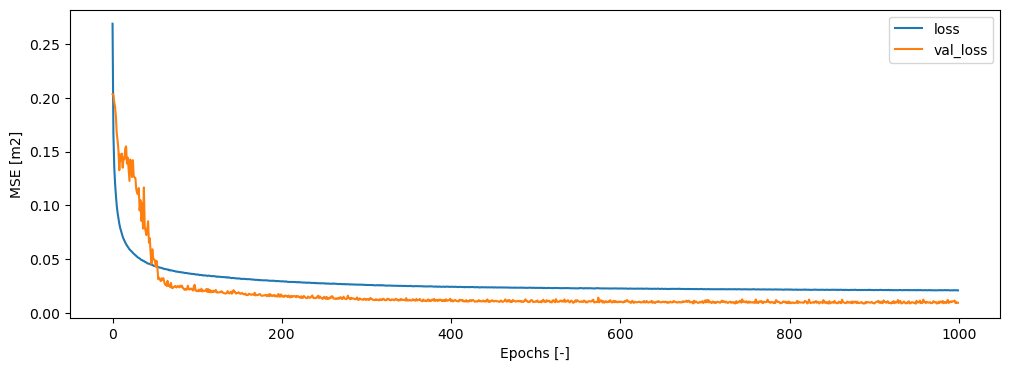

In [23]:
fig, ax = plt.subplots(figsize = (12, 4))
dfhist[['loss', 'val_loss']].plot(ax = ax)
ax.set_xlabel('Epochs [-]')
ax.set_ylabel('MSE [m2]')
fig.savefig(pathOut/f'trainValCurve_{modelID}_fold{fold}.png', dpi = 100, 
            bbox_inches = 'tight')

In [25]:
predictions = callback.best_model.predict(X_val2)

492/492 [==============================] - 3s 5ms/step


In [26]:
colsAux = ['Duck', 'Oregon', 'Hatteras', 'Beaufort', 'Wilmington', 'Wrightsville', 'Albemarle', 'Pamlico', 'Neuse']
dfVal = pd.DataFrame(y_val.reshape(y_val.shape[:2]), columns = colsAux)
dfPred = pd.DataFrame(predictions, columns = [f'{x}_pred' for x in colsAux])
dfAll = pd.concat([dfVal, dfPred], axis = 1)
dfAll.to_csv(pathOut/f'predValSet_{modelID}.csv')

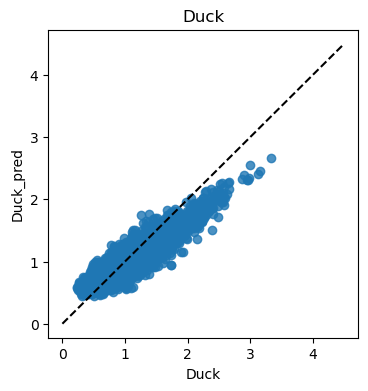

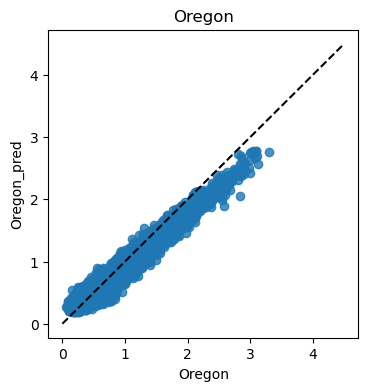

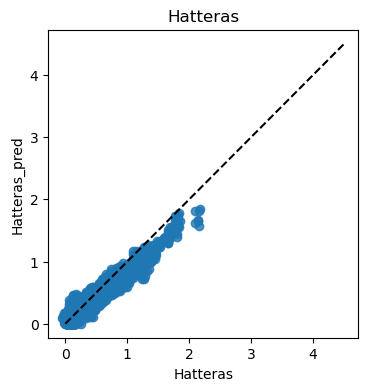

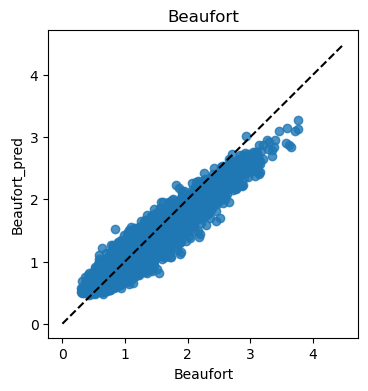

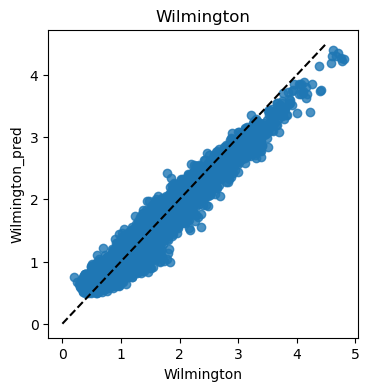

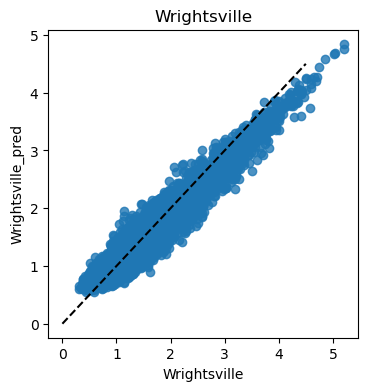

In [27]:
for i in range(6):
    fig, ax = plt.subplots(figsize = (4,4))
    sns.regplot(x = dfVal.iloc[:, i], y = dfPred.iloc[:, i], ax = ax, fit_reg = False)
    ax.plot(np.arange(0, 5, 0.5), np.arange(0, 5, 0.5), ls = '--', c = 'k')
    ax.set_title(f'{colsAux[i]}')
    fig.savefig(pathOut/f'predValSet_{modelID}_{colsAux[i]}.png',
                dpi = 100, bbox_inches = 'tight')

In [9]:
#### delete model
tf.keras.backend.clear_session()
del model
del optimizer
del callback